In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
from PIL import Image
from io import BytesIO
from pathlib import Path
import cv2
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader,Dataset

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import timm
from torchvision import transforms

In [2]:
root = "/kaggle/input"
root = os.path.join(root, "isic-2024-challenge")
train_img_dir=os.path.join(root,"train-image",'image')

train_metadata_dir=os.path.join(root,'train-metadata.csv')
test_metadata_dir=os.path.join(root,'test-metadata.csv')
train_img_hd5py_dir=os.path.join(root,'train-image.hdf5')
test_img_hdf5py_dir=os.path.join(root,'test-image.hdf5')

sample_sub_path=os.path.join(root,'sample_submission.csv')

In [3]:
sample_sub=pd.read_csv(sample_sub_path)
sample_sub

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


In [4]:
train_df=pd.read_csv(train_metadata_dir)
test_df=pd.read_csv(test_metadata_dir)

/tmp/ipykernel_25/2637033960.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df=pd.read_csv(train_metadata_dir)


In [5]:
train_df.head(5)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [6]:
test_df.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [7]:
train_images=list(Path(train_img_dir).glob('*.jpg'))
img=Image.open(train_images[99])
trans=transforms.Compose([transforms.PILToTensor()]) 
img=trans(img)

In [8]:
img.shape

torch.Size([3, 133, 133])

In [9]:
train_img_dir=train_img_dir
targets=train_df['target']
images=list(Path(train_img_dir).glob('*.jpg'))

In [10]:
class ISICDataset(Dataset):
    def __init__(self,train_img_dir,targets,transform=None):
        self.transform=transform
    def __len__(self):
        return len(target)
    def __getitem__(self,idx):
        img=Image.open(images[idx])
        if self.transform!=None:
            img=self.transform(img)
        tg=targets[idx]
        return img,tg

In [11]:
train_transform=transforms.Compose([
                transforms.RandomResizedCrop(size=224, scale=(0.4, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

In [12]:
train_dataset=ISICDataset(train_img_dir,train_df['target'],train_transform)

In [13]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.cpu().numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)

In [14]:
train_dataloader=DataLoader(train_dataset,batch_sampler=StratifiedBatchSampler(train_df['target'], batch_size=1023),pin_memory=True)

In [15]:
%%time
img, lb=next(iter(train_dataloader))

CPU times: user 22 s, sys: 1.66 s, total: 23.7 s
Wall time: 15.4 s


In [16]:
lb

tensor([0, 0, 0,  ..., 0, 0, 0])

In [17]:
torch.permute(img[lb==1],(0,2,3,1)).shape

torch.Size([1, 224, 224, 3])

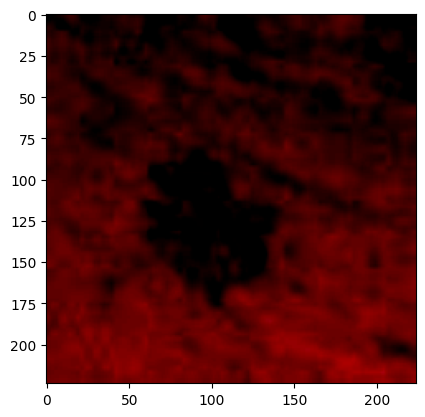

In [18]:
plt.imshow(np.squeeze(np.asarray(torch.permute(img[lb==1],(0,2,3,1)))))

In [19]:
img_2,lb_2=next(iter(train_dataloader))

In [20]:
lb_2

tensor([0, 0, 0,  ..., 0, 0, 0])

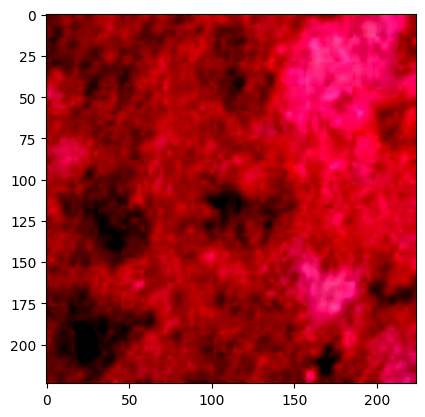

In [21]:
plt.imshow(np.squeeze(np.asarray(torch.permute(img_2[lb_2==1],(0,2,3,1)))))

In [22]:
img[0].dtype,lb[0].dtype

(torch.float32, torch.int64)

In [23]:
img.shape

torch.Size([1024, 3, 224, 224])

In [24]:
train_df_p=train_df[train_df['target']==1]

<Axes: xlabel='age_approx', ylabel='count'>

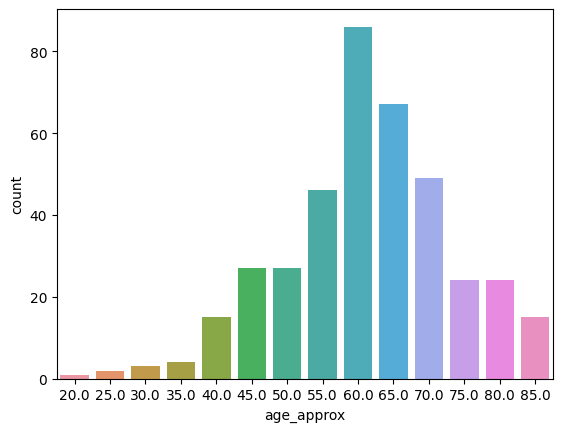

In [25]:
sns.countplot(train_df_p,x='age_approx')

In [26]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [27]:
def freeze_pretrained_layers(model):
    '''Freeze all layers except the last layer(fc or classifier)'''
    for param in model.parameters():
            param.requires_grad = False
    model.classifier.weight.requires_grad = True
    model.classifier.bias.requires_grad = True

In [28]:
freeze_pretrained_layers(model)
model.classifier.weight.requires_grad

True

In [29]:
print(model.classifier)

Linear(in_features=1280, out_features=1, bias=True)


In [30]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(params=model.parameters(), lr=1e-3)
LR_SCHEDULER=torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1,last_epoch=-1)

In [31]:
a=torch.rand(img.shape)

In [32]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [34]:
a.shape
a=a.to(device)

In [35]:
p=model(a)
p.shape

torch.Size([1024, 1])

In [36]:
def pauc(y_true, y_pred):
    y_true=y_true.cpu()
    y_pred=y_true.cpu().detach()
    min_tpr=0.8
    v_gt = abs(np.asarray(y_true)-1)    
    v_pred = np.array([1.0 - x for x in y_pred])
    max_fpr = abs(1-min_tpr)   
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)   
    return partial_auc

In [37]:
def train_model(model,device,train_dataloader,loss_fn,optimizer):
    
    model=model.to(device)
    
    train_loss=0
    train_score=0
    for X,y in train_dataloader:
        X=X.to(device)
        y=y.to(device).reshape(-1,1).to(torch.float32)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            pred=model(X)
            loss=loss_fn(pred,y)
        train_loss+=loss
        optimizer.step()
        loss.backward()
        y_pred=torch.round(torch.nn.functional.sigmoid(pred))
        train_score+=pauc(y,y_pred)
    train_loss/=len(train_dataloader)
    train_score/=len(train_dataloader)
    print(f'train_loss={train_loss} | train_score={train_score}')
    return train_loss,train_score

In [38]:
device

'cuda'

In [39]:
epochs=1
train_loss=[]
train_score=[]
for epoch in tqdm(range(epochs)):
    l,s=train_model(model,device,train_dataloader,loss_fn,optimizer)
    train_loss.append(l)
    train_score.append(s)

100%|██████████| 1/1 [1:30:33<00:00, 5433.32s/it]

train_loss=0.004009579308331013 | train_score=0.00019548246018665725
